In [201]:
import pandas as pd
import numpy as np
import math
import scipy.stats as scist
from scipy.stats import t as sct
import csv
import statistics as st
import matplotlib.pyplot as plt
import statistics
from matplotlib.ticker import FormatStrFormatter
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import seaborn as sns
import random
from copy import copy, deepcopy
from bs4 import BeautifulSoup as bs
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Czr19\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Czr19\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### This project trained various machine learning models with bag-of-words and TF-IDF transformers respectively on 550390 random tweets, then selected the best model and predicted the sentiment for tweets from another dataset regarding the Canadian PM election. 

In [3]:
#extractStr(content,head=str,tail=str,hnum=1,tnum=1)
#returns the content between head and tail, excluding head and tail
#head is a substring in content that specifies the head of the content to be returned (head itself is excluded)
#tail is a substring in content that specifies the tail of the content to be returned (tail itself is excluded)
#hnum specifies the count of the head substring in content that should be specified as head, 1 is the first one
#tnum specifies the count (scanning reversely) of the tail substring in content that should be specified as tail, 1 is the last one
#if hnum exceeds the total count of head substrings in content, the last one will be considered
#if tnum exceeds the total count of tail substrings in content, the first one will be considered
#example: extractStr('1abc2abc3abc 456def7def',head='abc',tail='def',hnum=2,tnum=999)
#will return '3abc 456'
def extractStr(content,**boundstr):
    try:
        content=str(content)
    except:
        return(None)
    head=boundstr.get('head','')
    tail=boundstr.get('tail','')
    hnum=boundstr.get('hnum',1)
    tnum=boundstr.get('tnum',1)
    exstr=''
    a=0
    a2=-len(head)+1
    b=0
    b2=-len(tail)+1
    clen=len(content)
    hcount=0
    tcount=0
    if not head==None:
        i=0
        if not head=='':
            for i in range(clen):
                a+=1
                if head==content[i:i+len(head)]:
                    a2=a
                    hcount+=1
                    if hcount==hnum:
                        break
        else:
            a=1
            a2=1
        for j in range(clen,i+len(head),-1):
            b+=1
            if tail==content[j-len(tail):j]:
                tcount+=1
                b2=b
                if tcount==tnum:
                    break
    headdex=a2+len(head)-1
    taildex=len(content)-b2-len(tail)+1
    if headdex>taildex:
        exstr=''
    else:
        exstr=content[headdex:taildex]
    return exstr

In [4]:
'aliesrcbfiela'.find('ie')

2

In [5]:
#Functionally same as extractStr() but uses Python's built in find() to get index of substring
def extractStr2(content0,**boundstr):
    content=content0
    try:
        content=str(content)
    except:
        return(None)
    head=boundstr.get('head','')
    tail=boundstr.get('tail','')
    hnum=boundstr.get('hnum',1)
    tnum=boundstr.get('tnum',1)
    found=-2
    cutted=0
    hdexs=[0]
    while not found==-1 or found==0:
        found=content.find(head)
        if found==-1 or found==0:
            break
        hdexs.append(found+cutted+len(head))
        cutted=cutted+found+len(head)
        content=content[found+len(head):]
    content=content0
    try:
        content=str(content)
    except:
        return(None)
    found=-2
    cutted=0
    tdexs=[len(content0)]
    while not found==-1 or found==0:
        found=content.find(tail)
        if found==-1 or found==0:
            break
        tdexs.append(found+cutted)
        cutted=cutted+found+len(tail)
        content=content[found+len(tail):]
    headdex=0
    try:
        headdex=hdexs[hnum]
    except:
        headdex=hdexs[-1]
    taildex=0
    if len(tdexs)>tnum:
        taildex=tdexs[len(tdexs)-tnum]
    else:
        taildex=tdexs[0]
    if headdex>taildex:
        exstr=''
    else:
        exstr=content0[headdex:taildex]
    return exstr
        

In [6]:
extractStr2('abcdqwefg1qw234oplfnciwopl',head='qw',hnum=3,tail='wo',tnum=1)

'234oplfnci'

In [7]:
# takes a single dataframe or a dict of dataframes, convert it (them) from number-based to percentage-based
def count2percent4df(dfobj): 
    if type(dfobj)==dict:
        result={} #input dict->return dict
        for adomain in dfobj:
            df=dfobj[adomain]
            columns=list(df.columns)
            mydf=pd.DataFrame()
            mydf.loc[:,columns[0]]=df.loc[:,columns[0]] #select the column to convert
            mydf.loc[:,'percent']=df.loc[:,'count']/df.loc[:,'count'].sum()*100 #convert from number to percentage
            result[adomain]=mydf
        return result
    #input single DF->return single DF
    df=dfobj
    columns=list(df.columns)
    mydf=pd.DataFrame()
    mydf.loc[:,columns[0]]=df.loc[:,columns[0]]
    mydf.loc[:,'percent']=df.loc[:,'count']/df.loc[:,'count'].sum()*100
    return mydf.drop('count',axis=1)

In [ ]:
def trunk(ndict,head,tail): #trunks a dict by index
    redict={};
    nkeys=list(ndict.keys());
    if head<=0 and tail>=len(nkeys):
        return ndict
    nvals=list(ndict.values());
    for i in range(head,min(tail,len(nkeys))):
        redict[nkeys[i]]=nvals[i]
    return redict
def numDictRank(ndict): #ranks a dict with numbers in the values, from high to low
    redict={};
    nkeys=list(ndict.keys());
    nvals=np.array(list(ndict.values()));
    for i in range(0,len(nkeys)):
        nmaxdex=np.argmax(nvals);
        redict[nkeys[nmaxdex]]=nvals[nmaxdex];
        nvals=np.delete(nvals, nmaxdex)
        del nkeys[nmaxdex]
    return redict

#takes a string, counts the occupancy of each appeared word, 
#returns the top wantnum (being a int) words together with the occupancy of each as a dict
def countFreqWords(content,**settings): 
    wantnum=settings.get('num',999)
    numtype=settings.get('numtype','count')
    ranked=settings.get('ranked',True)
    
    if type(content)==str:
        content=content.split()
    leng=len(content)
    ret={}
    for word in content:
        try: 
            ret[word]=ret[word]+1
        except KeyError:
            ret[word]=1
    if ranked:
        ret=numDictRank(ret)
    if numtype=='percent':
        ret={k: v/leng*100 for k, v in ret.items()}
    return trunk(ret,0,wantnum)

## Data Cleaning

The whole dataframe has 550390 rows, which is too big to be cleaned at once. Although it is tested that the loc[] operation is greatly faster than the iloc[] operation, its speed decreases drastically as the dataset becomes larger. Thus, the whole dataset is separated into 551 small datasets, 550 of which have length 1000 and one of which has length 390. 

To clean each tweet, in order to remove the nickname and the URLs, a function extractStr() is written for extracting the portion between two specified substrings of a string. The tweet will first be judged if the substring ‘RT @’ is in the first 4 characters. If yes, the substring between the first ‘:’ and the first ‘https:’ will be extracted and the remaining will be discarded (the nickname is before the first ‘:’ thus discarded). If no, then the portion from the beginning to the first ‘https:’ will be kept. The extractStr() function will not cut the tail of the string if the specified substring as the tail is not found in the tweet. Then the html character codes are removed. To do this, any occurrence of a ‘;’ following a ‘&’ separated by within 3 chars will be removed. They are removed as ASCII codes basically do not contain any sentiment. Later, every char is turned to lower case by lower(). Afterwards, the RegexpTokenizer from nltk is used for tokenizing each tweet into word strings. This tokenizer automatically discards any symbol. Therefore, the html tags and attributes will be removed. Finally, the tokenized word list will be checked by a loop for removing stopwords. The stopword pool is downloaded from nltk. 

For each separated small dataframe, the above operations are performed on each item in the text column. Each 25 small dataframes are cleaned at once in one loop, except the last small dataframe is cleaned individually. The reason why not clean all 551 small dataframes at once is because it will get increasingly slow as it runs, probably due to cache running out. Thus, the cleaning work is separated to 23 steps. When cleaning is done, the 551 small dataframes will be exchanged back into the original big dataframe. The whole cleaning work will take less than 10 minutes in this way.

In [9]:
#by experimenting, the loc[] operation for dataframe is exponentially slower when the length of the dataframe is larger
#thus the whole dataframe is splited into 551 smaller dataframes each with length 1000
sadf00 = pd.read_csv('sentiment_analysis.csv')
sadfs=[]
for i in range(552):
    subdf=sadf00[i*1000:(i+1)*1000]
    sadfs.append(subdf)

In [10]:
sadfs

[               ID                                               text  label
 0    7.680980e+17  Josh Jenkins is looking forward to TAB Breeder...      1
 1    7.680980e+17  RT @MianUsmanJaved: Congratulations Pakistan o...      1
 2    7.680980e+17  RT @PEPalerts: This September, @YESmag is taki...      1
 3    7.680980e+17  RT @david_gaibis: Newly painted walls, thanks ...      1
 4    7.680980e+17  RT @CedricFeschotte: Excited to announce: as o...      1
 ..            ...                                                ...    ...
 995  7.681090e+17  RT @LakeridgeWinery: Muscadine Harvest kicked ...      1
 996  7.681090e+17  RT @AlyssaValdez2: Good night. ✌🏻️ https://t.c...      1
 997  7.681090e+17  Happy birthday @kobebryant 💯 #blackmamba ⚫️🐍 🐐...      1
 998  7.681090e+17  RT @shfly3424: The day to thank my parents  :)...      1
 999  7.681090e+17  "he loves pickles!"Love this show... filling t...      1
 
 [1000 rows x 3 columns],
                 ID                             

In [11]:
#this function cleans 25 small dataframes with length 1000 each
def cleanBlock(block,incre):
    global sadfs
    n=0
    start=block
    for sadf in sadfs[start:start+incre]:
        if n%4==0:
            print (n)
        for i in range(len(sadf)):
            ex=sadf.iloc[i,1]
            #clean ASCII codes
            try:
                amdex=-1;
                semdex=-1;
                for a in range(len(ex)):
                    if ex[a]=='&':
                        amdex=a;
                        break
                for b in range(amdex,min(amdex+5,len(ex))):
                    if ex[b]==';':
                        semdex=b;
                        break;
                if amdex>-1 and semdex>-1:
                    if semdex+1<=len(ex):
                        ex=ex[0:amdex]+ex[semdex+1:]
                    else:
                        ex=ex[0:amdex]
            except:
                pass
            #clean nicknames and URLs
            if 'RT @'in ex[0:4]:
                ex=extractStr(ex,head=':',tail='https',hnum=1,tnum=5)
            else:
                ex=extractStr(ex,tail='https',hnum=1,tnum=5)
            #tokenize and clean stopwords
            stopw = set(stopwords.words('english'))
            tokenizer = RegexpTokenizer(r'\w+')
            wtokens=tokenizer.tokenize(ex)
            filtered = [w.lower() for w in wtokens if not w.lower() in stopw]
            sadf.loc[1000*(start+n)+i,'text']=' '.join(filtered)
        n+=1

In [12]:
#cleaning for all smaller dataframes is NOT to be done with in one loop because it gets slower and slower as it keeps running
#Instead, the 551 smaller dataframes are separated into 23 groups to be run separately
cleanBlock(0,25)

0


D:\Programs\anaconda\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


4
8
12
16
20
24


In [13]:
cleanBlock(25,25)

0
4
8
12
16
20
24


In [14]:
cleanBlock(50,25)

0
4
8
12
16
20
24


In [15]:
cleanBlock(75,25)

0
4
8
12
16
20
24


In [16]:
cleanBlock(100,25)

0
4
8
12
16
20
24


In [17]:
cleanBlock(125,25)

0
4
8
12
16
20
24


In [18]:
cleanBlock(150,25)

0
4
8
12
16
20
24


In [19]:
cleanBlock(175,25)

0
4
8
12
16
20
24


In [20]:
cleanBlock(200,25)

0
4
8
12
16
20
24


In [21]:
cleanBlock(225,25)

0
4
8
12
16
20
24


In [22]:
cleanBlock(250,25)

0
4
8
12
16
20
24


In [23]:
cleanBlock(275,25)

0
4
8
12
16
20
24


In [24]:
cleanBlock(300,25)

0
4
8
12
16
20
24


In [25]:
cleanBlock(325,25)

0
4
8
12
16
20
24


In [26]:
cleanBlock(350,25)

0
4
8
12
16
20
24


In [27]:
cleanBlock(375,25)

0
4
8
12
16
20
24


In [28]:
cleanBlock(400,25)

0
4
8
12
16
20
24


In [29]:
cleanBlock(425,25)

0
4
8
12
16
20
24


In [30]:
cleanBlock(450,25)

0
4
8
12
16
20
24


In [31]:
cleanBlock(475,25)

0
4
8
12
16
20
24


In [32]:
cleanBlock(500,25)

0
4
8
12
16
20
24


In [33]:
cleanBlock(525,25)

0
4
8
12
16
20
24


In [34]:
cleanBlock(550,1)

0


In [35]:
#substitute small dataframes into the original big one
sadf=sadf00.copy()
#sadf2[0:2000]=sadfs[1]
for n in range(552):
    sadf[n*1000:(n+1)*1000]=sadfs[n]
sadf

,ID,text,label
0,7.680980e+17,josh jenkins looking forward tab breeders crow...,1
1,7.680980e+17,congratulations pakistan becoming no1testteam ...,1
2,7.680980e+17,september yesmag taking maine mendoza surprise...,1
3,7.680980e+17,newly painted walls thanks million custodial p...,1
4,7.680980e+17,excited announce july 2017 feschotte lab reloc...,1
...,...,...,...
550386,8.046170e+17,goddesses_o stop watching mm,0
550387,8.046180e+17,poor old tom odell look like would know wrong ...,0
550388,8.046180e+17,antsmasher smashed 7 ants awesome game hjfjfi,1
550389,8.046180e+17,lizhudston kymwyllie evasmiless meanbok linddy...,1


In [36]:
#get a collection of all texts
try:
    sadf=sadf.drop('ID',axis=1)
except:
    pass
sacollect=''
for i in range(len(sadf)):
    if i%50000==0:
        print(i)
    sacollect=sacollect+sadf.loc[i,'text']
sacollect=sacollect.split()
sacollect

0
50000
100000
150000
200000
250000
300000
350000
400000
450000
500000
550000


['josh',
 'jenkins',
 'looking',
 'forward',
 'tab',
 'breeders',
 'crown',
 'super',
 'sundaycongratulations',
 'pakistan',
 'becoming',
 'no1testteam',
 'world',
 'odds',
 'ji_pakzindabadralliesseptember',
 'yesmag',
 'taking',
 'maine',
 'mendoza',
 'surprise',
 'thanksgiving',
 'party',
 'threw',
 'fansnewly',
 'painted',
 'walls',
 'thanks',
 'million',
 'custodial',
 'painters',
 'summer',
 'great',
 'job',
 'ladies',
 'ec_proudexcited',
 'announce',
 'july',
 '2017',
 'feschotte',
 'lab',
 'relocating',
 'cornell',
 'mbgexcited',
 'illuminatefirstdayofschool',
 'students',
 'teachers',
 'good',
 'luck',
 'successful',
 '2016',
 '17',
 'school',
 'year',
 'educationmatters',
 'htsrk',
 'kajol',
 'making',
 'ddlj',
 'song',
 'greatest',
 'everhappykathryn',
 'daniel',
 'share',
 'memorable',
 'experience',
 'barcelona',
 'see',
 'interviewlots',
 'fun',
 'skypehappy',
 'birthday',
 'handsome',
 'kid',
 'world',
 'love',
 'u',
 'like',
 'son',
 'never',
 'congrats',
 'l',
 'snavits

In [37]:
#remove unnecessary columns
try:
    sadf=sadf.drop(['Unnamed: 0','ID'],axis=1)
except:
    pass
sadf=sadf.dropna().reset_index().drop('index',axis=1)
sadf

,text,label
0,josh jenkins looking forward tab breeders crow...,1
1,congratulations pakistan becoming no1testteam ...,1
2,september yesmag taking maine mendoza surprise...,1
3,newly painted walls thanks million custodial p...,1
4,excited announce july 2017 feschotte lab reloc...,1
...,...,...
550386,goddesses_o stop watching mm,0
550387,poor old tom odell look like would know wrong ...,0
550388,antsmasher smashed 7 ants awesome game hjfjfi,1
550389,lizhudston kymwyllie evasmiless meanbok linddy...,1


## Check party affiliation and sentiment of each tweet

In [169]:
cedf = pd.read_csv('Canadian_elections_2021.csv')
cedf.loc[:,'Party']=['Other']*(len(cedf))
cecollect=[]
#Clean the canadian elections dataset and label party affiliations in a separate column
for i in range(len(cedf)):
    ex=cedf.iloc[i,0]
    wdeter=ex.split()
    wdeter=[w.lower() for w in wdeter] #used for party affiliation distinguishing, NOT cleaned
    amdex=-1;
    semdex=-1;
    for a in range(len(ex)):
        if ex[a]=='&':
            amdex=a;
            break
    for b in range(amdex,min(amdex+5,len(ex))):
        if ex[b]==';':
            semdex=b;
            break;
    if amdex>-1 and semdex>-1:
        if semdex+1<=len(ex):
            ex=ex[0:amdex]+ex[semdex+1:]
        else:
            ex=ex[0:amdex]
    if 'RT @'in ex[0:4]:
        ex=extractStr(ex,head=':',tail='https',hnum=1,tnum=5)
    else:
        ex=extractStr(ex,tail='https',hnum=1,tnum=5)
    stopw = set(stopwords.words('english'))
    tokenizer = RegexpTokenizer(r'\w+')
    wtokens=tokenizer.tokenize(ex)
    
    filtered = [w.lower() for w in wtokens if not w.lower() in stopw]
    cedf.iloc[i,0]=' '.join(filtered)
    cecollect=cecollect+filtered
    #determine party
    #first check the uncleaned but lowered and splitted tweet for tags
    #if there are tags for supporting two or more parties, randomly select one
    #Then check the positive tweets for parties mentioned, using the cleaned and splitted version of tweet
    #get all the parties mentioned in a positive tweet and randomly select one
    aff='Other'
    myaffs=[]
    for j in range(len(wdeter)-1,0,-1):        
        if wdeter[j] in ['#istandwithtrudeau','#standwithtrudeau','#voteliberal','#liberalmajority']:
            myaffs.append('Liberal')
        elif wdeter[j] in ['#votecpc', '#voteconservative','#otooleforpm'] :
            myaffs.append('CPC')
        elif wdeter[j] in ['#votendp','#readyforbetter','#votendp2021','#jagmeetsingh']:
            myaffs.append('NDP')
        elif wdeter[j] in ['#voteppc','#voteppc2021','#freedom','#purplewave','#maximebernierforpm']:
            myaffs.append('PPC')
    if len(myaffs)>0:
        aff=myaffs[random.randint(0,len(myaffs)-1)]
    if aff=='Other':
        if cedf.loc[i,'sentiment']=='positive':
            myaffs=[]
            for j in range(len(filtered)-1,0,-1):
                if filtered[j] in ['trudeau','justintrudeau','liberal','liberals','pmjt','jt','justin']:
                    myaffs.append('Liberal');
                elif filtered[j] in ['erinotoole','otoole','toole','cpc_hq','cpc','conservative','conservatives','erin']:
                    myaffs.append('CPC')
                elif filtered[j] in ['ppc','maximebernier','bernier','maxime','maxine','maxinebernier','peoplespca']:
                    myaffs.append('PPC')
                elif filtered[j] in ['ndp','npd','singh','jagmeet','jagmeetsingh']:
                    myaffs.append('NDP')
            if len(myaffs)>0:
                aff=myaffs[random.randint(0,len(myaffs)-1)]
        else:
            pass
    cedf.loc[i,'Party']=aff

sentiment=cedf.loc[:,'sentiment']
for i in range (len(sentiment)):
    if sentiment[i]=='positive':
        sentiment[i]=1
    else:
        sentiment[i]=0
cedf.loc[:,'sentiment']=sentiment               
cedf[0:40]

,text,sentiment,negative_reason,Party
0,canadian election power grab pm trudeau yes ta...,0,calling election early,Other
1,hope trudeau loses canadian election tomorrow ...,0,covid,Other
2,dear canadians election test progressive wheth...,1,NaN,Other
3,canadian friends never forget trudeau 2 years ...,0,calling election early,Other
4,sorry thejagmeetsingh voted ndp life election ...,1,NaN,PPC
5,vaccines guns key election toole serious plan ...,0,covid,Other
6,sorry moderators respond leadership candidates...,0,others,Other
7,say skeptical critical mainstream canadian jou...,0,others,Other
8,canadians voteppc support maximebernier would ...,1,NaN,PPC
9,justin trudeau literally rocks thrown yet cont...,1,NaN,Liberal


In [102]:
#when want to study the portion of each word in a word pool, if the pool is too big, use this function to take a random sample from
#the pool to analysis
def subsample(ls,snum): 
    randexs=[]
    ret=[]
    if snum>=len(ls):
        return ls
    i=0
    while i<(snum):
        ranum=random.randint(0,len(ls)-1)
        if not ranum in randexs:
            randexs.append(ranum)
        else:
            i-=1
        i+=1
    for dex in randexs:
        ret.append(ls[dex])
    return ret
st='a bb ccc dddd eeeee ffffff ggggggg dddd eeeee ccc dddd ccc ccc '.split()
subsample(st,6)

['ccc', 'dddd', 'ccc', 'eeeee', 'dddd', 'a']

In [170]:
cedf.groupby('Party').count()

,text,sentiment,negative_reason
Party,,,
CPC,130,130,3
Liberal,191,191,12
NDP,28,28,1
Other,578,578,362
PPC,75,75,9


Text(0.5, 1.0, 'Party affiliation distribution of the identified tweets')

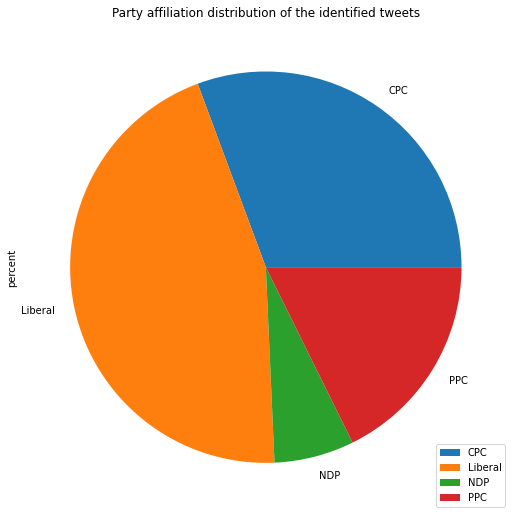

In [348]:
#plot the party affiliation distribution in a pie plot, excluding 'Other'
ptycounts0=pd.DataFrame(cedf.groupby('Party').count().loc[:,'text'])
ptycounts=ptycounts0.copy().drop('Other')
ptycounts.columns.values[0]='count'
ptycounts=count2percent4df(ptycounts)
ptycounts.plot(kind='pie',subplots=True,figsize=[9,9])
plt.title('Party affiliation distribution of the identified tweets')

In the reality, Liberal got the most votes, followed by CPC, then NDP, finally PPC. In the pie chart shown above, Liberal does have the largest population of affiliation and CPC is the second, which meets the reality. But in the chart PPC seems more popular than acutal. Considering the small size of the dataset and the further shrinked size of the identified samples, this error is possible.

## Applying bag of words and TF-IDF

In [208]:
sasubcollect=subsample(sacollect,40000)
safreq=countFreqWords(sasubcollect,num=50,numtype='percent')
safreqdf=pd.DataFrame(safreq,index=['Frequency']).transpose()
cefreq=countFreqWords(cecollect,num=50,numtype='percent')
cefreqdf=pd.DataFrame(cefreq,index=['Frequency']).transpose()
#print(safreqdf)
#print(cefreqdf)

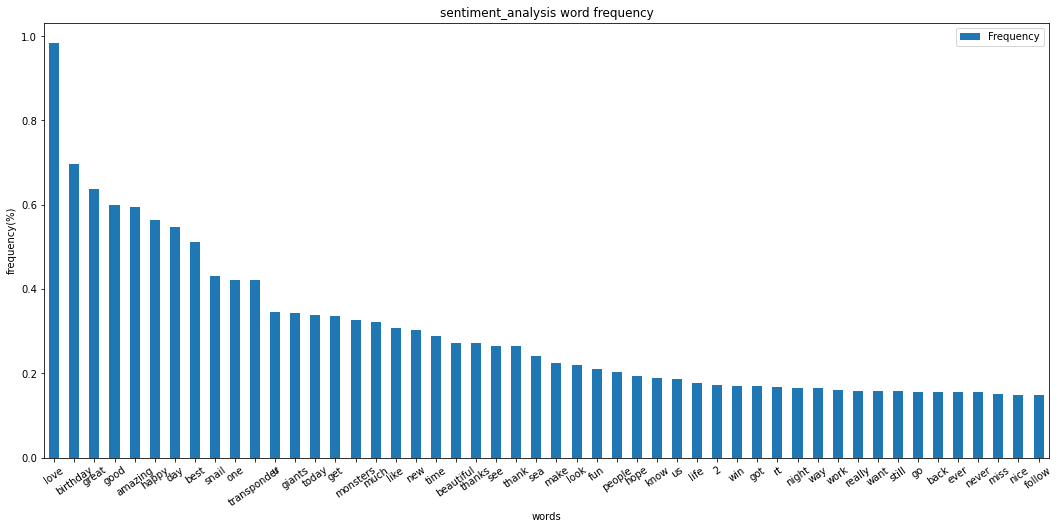

In [347]:
safreqdf.plot(kind='bar', figsize=[18,8])
plt.title('sentiment_analysis word frequency')
plt.xlabel('words')
plt.ylabel('frequency(%)')
plt.xticks(rotation=35)
plt.show()

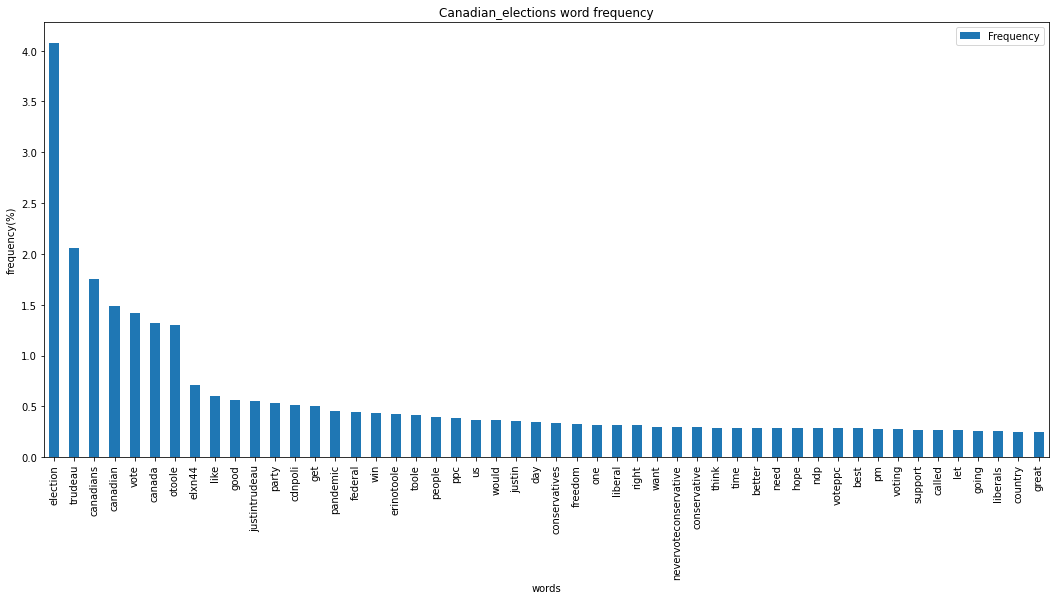

In [346]:
cefreqdf.plot(kind='bar', figsize=[18,8])
plt.title('Canadian_elections word frequency')
plt.xlabel('words')
plt.ylabel('frequency(%)')
plt.xticks(rotation=90)
plt.show()

The high frequency words in the two datasets are very different. The top three words in the sentiment analysis dataset ('love','birthday','great') do not even find their positions in the top 49 frequent words in the Canadian election dataset.As for the Canadian election dataset, most of its high frequent words are about the election event and the parties, which would have a pretty low frequency in the sentiment analysis dataset. Therefore, these two datasets are naturally very different.Also, there are far fewer words reflecting sentiment (such as 'love' or 'hate') in the Canadian election dataset, which may make it hard for the predictions later.

In [44]:
#free up some memory
del sadf00
del sadfs

In [45]:
#needs countFreqWords() 
#functionally similar to CountVectorizer().fit_transform() when kind='count' 
#but outputs with order of columns (words) ranked from high frequency to low 
#and allows trunking for the highest frequency Xnum words
#also allows custom input wordpool and specifying the desired features (words) as the columns in the output
#The CountVectorizer always include all features and rank them in an alphabetical order, which makes it hard for feature deduction
#But this function only works for smaller datasets like the canadian election dataset, it will require too much memory for a big dataset
#and this function will be used for the canadian election dataset for specifying the features to be the same as the sentiment analysis one
def text2count4df(df,textcol,**kwargs): 
    Xnum=kwargs.get('Xnum',5)
    kind=kwargs.get('kind','count')
    textlist=list(df.loc[:,textcol])
    cols=list(kwargs.get('cols',[]))
    wordpool=kwargs.get('wordpool',[])
    retype=kwargs.get('retype','df')
    retcols=[]
    if len(cols)==0:
        words=[]
        if len(wordpool)==0:
            print('len(wordpool)==0')
            for sentence in textlist:
                words=words+(sentence.split())
        else:
            print('len(wordpool)!=0')
            try:
                words=wordpool.split()
            except:
                words=wordpool
            print('words formed')
        countdict=countFreqWords(words,num=99999999)
        retcols=list(countdict.keys())[0:Xnum]
    else:
        retcols=cols
    print('retcols num:',len(retcols))
    #print(retcols)
    colsdict={}
    for i in range(len(retcols)):
        colsdict[retcols[i]]=np.zeros(len(textlist))
    print('colsdict formed')
    rownum=-1
    sn=0
    for sentence in textlist:
        sn+=1
        if sn%50000==0:
            print(sn)
        try:
            sspl=sentence.split()
        except:
            #print(sn)
            sspl=str(sspl)
        rownum+=1
        rowcountdict=countFreqWords(sspl)
        rowkeys=list(rowcountdict.keys())
        rowvals=list(rowcountdict.values())
        for i in range(0,len(rowkeys)):
            try:
                if kind=='count':
                    colsdict[rowkeys[i]][rownum]=rowvals[i]
                elif kind=='bag':
                    colsdict[rowkeys[i]][rownum]=rowvals[i]/len(sspl)
            except:
                #print(rownum,rowkeys[i],rowvals[i])
                pass
    if retype=='dict':
        return colsdict
    retdf=df.copy()
    retdf=retdf.drop('text',axis=1)
    for i in range(0,len(list(colsdict.keys()))):
        retdf.insert(loc=i,column=list(colsdict.keys())[i],value=list(colsdict.values())[i])
    return retdf

In [46]:
#Specifying 3200 features (words) to be considered 
#get a dict of the 3200 highest frequency words in all texts
Xnum=3200
safeatures=countFreqWords(subsample(sacollect,40000),num=Xnum)
safeatures

{'love': 409,
 'birthday': 266,
 'amazing': 251,
 'good': 247,
 'great': 237,
 'best': 234,
 'day': 213,
 'happy': 207,
 'one': 170,
 'transponder': 165,
 'like': 162,
 'snail': 162,
 'u': 130,
 'new': 129,
 'much': 126,
 'get': 125,
 'beautiful': 121,
 'thanks': 121,
 'thank': 120,
 'monsters': 117,
 'sea': 113,
 'time': 112,
 'giants': 108,
 'see': 95,
 'make': 94,
 'hope': 93,
 'people': 93,
 'us': 90,
 'today': 89,
 'win': 82,
 'back': 80,
 'rt': 77,
 'fun': 76,
 '2': 76,
 'ever': 76,
 'got': 71,
 'look': 71,
 'go': 69,
 'never': 67,
 'come': 66,
 'life': 64,
 'night': 63,
 'way': 61,
 'know': 61,
 'year': 58,
 'miss': 58,
 'really': 57,
 'work': 56,
 'still': 55,
 'enjoy': 55,
 '3': 54,
 'perfect': 54,
 'im': 54,
 'nice': 54,
 'awesome': 53,
 'bad': 53,
 'morning': 52,
 'trump': 51,
 'want': 51,
 '4': 50,
 'going': 50,
 'guys': 49,
 'tonight': 49,
 'free': 49,
 'girl': 49,
 'world': 49,
 'always': 48,
 'would': 48,
 'cute': 48,
 'let': 48,
 'right': 48,
 '1': 47,
 'man': 47,
 'eve

In [47]:
#use the CountVectorizer to apply bag of words and will get a sparse matrix with columns ranked in alphabetical order of features
vecterbag=CountVectorizer()
sabagvz=vecterbag.fit_transform(sadf.loc[:,'text'])


In [48]:
#get a list of the most frequent 3200 words
safeatlist=list(safeatures.keys())
safeatlist

['love',
 'birthday',
 'amazing',
 'good',
 'great',
 'best',
 'day',
 'happy',
 'one',
 'transponder',
 'like',
 'snail',
 'u',
 'new',
 'much',
 'get',
 'beautiful',
 'thanks',
 'thank',
 'monsters',
 'sea',
 'time',
 'giants',
 'see',
 'make',
 'hope',
 'people',
 'us',
 'today',
 'win',
 'back',
 'rt',
 'fun',
 '2',
 'ever',
 'got',
 'look',
 'go',
 'never',
 'come',
 'life',
 'night',
 'way',
 'know',
 'year',
 'miss',
 'really',
 'work',
 'still',
 'enjoy',
 '3',
 'perfect',
 'im',
 'nice',
 'awesome',
 'bad',
 'morning',
 'trump',
 'want',
 '4',
 'going',
 'guys',
 'tonight',
 'free',
 'girl',
 'world',
 'always',
 'would',
 'cute',
 'let',
 'right',
 '1',
 'man',
 'even',
 'god',
 'find',
 'family',
 'real',
 'thanksgiving',
 'stop',
 'home',
 'need',
 'last',
 'big',
 'follow',
 'little',
 'fuck',
 'looking',
 'team',
 'please',
 'show',
 'proud',
 'must',
 'weekend',
 '2016',
 'made',
 'looks',
 'cool',
 'years',
 'game',
 'wait',
 'local',
 'fucking',
 'friends',
 'favorite'

In [49]:
fnames=vecterbag.get_feature_names() #get the 300000+ features given by the CountVectorizer
'''The algorithm below selects 3200 columns from the 300000+ columns of the sparse matrix corresponging to the most frequent 3200 words 
determined before, and the selected columns will be ranked from high to low frequency'''
#using the max_features kwarg is avoided because it does not automatically reserve the features of the most frequent words
sabagfeatdexs=[]
i=0
while i<len(safeatlist):
    j=0
    while j<len(fnames):
        #print(safeatlist[i])
        #print(fnames[j])
        if fnames[j]==safeatlist[i]:
            sabagfeatdexs.append(j)  
            break
        j+=1
    i+=1  
#There will be slightly fewer than 3200 features finally because there were word repetitions in the 3200 words, which are now eliminated
len(sabagfeatdexs)

3116

In [50]:
#unify the feature names and the feature columns
fnames=np.array(fnames)[sabagfeatdexs]
sabagvz=sabagvz[:,sabagfeatdexs]
print(len(fnames))
print(sabagvz.shape)
fnames

3116
(550391, 3116)


array(['love', 'birthday', 'amazing', ..., 'watermelon', 'kyungsoo',
       'pakistani'], dtype='<U94')

In [51]:
#Transform as TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
tfidfTF= TfidfTransformer(smooth_idf=False)
satfvz=tfidfTF.fit_transform(sabagvz)
subsa=satfvz[0:10,:].toarray()
subsadf=pd.DataFrame(subsa,columns=list(fnames))
subsadf

,love,birthday,amazing,good,great,best,day,happy,one,transponder,...,attractive,advertising,multiple,dramatic,lesdoggg,buzzing,anybody,watermelon,kyungsoo,pakistani
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.191906,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.201613,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## ML models training
#### In the training part, the accuracy is assessed on the test set separated from the random tweets dataset. The accuracy on the PM election dataset will be lower.

In [52]:
#split the bag of words dataset and the TF-IDF dataset into training and testing data after transforming
ysa=sadf.loc[:,'label']
Xsabagtrain, Xsabagtest, ysabagtrain, ysabagtest = train_test_split(sabagvz,ysa,test_size=0.3)
Xsatftrain, Xsatftest, ysatftrain, ysatftest = train_test_split(satfvz,ysa,test_size=0.3)

In [53]:
#logistic regression
modelbagLR = LogisticRegression()
modelbagLR.fit(Xsabagtrain,ysabagtrain)

D:\Programs\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [54]:
#bag of words
predsabagLR = modelbagLR.predict(Xsabagtest)
accsabagLR=accuracy_score(ysabagtest,predsabagLR)
accsabagLR
#accuracy

0.9492241911844862

In [55]:
modeltfLR = LogisticRegression()
modeltfLR.fit(Xsatftrain,ysatftrain)

D:\Programs\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [56]:
#TF-IDF
predsatfLR = modeltfLR.predict(Xsatftest)
accsatfLR=accuracy_score(ysatftest,predsatfLR)
accsatfLR
#accuracy

0.9486912389927203

In [57]:
#k-NN
from sklearn.neighbors import KNeighborsClassifier
modelbagKN=KNeighborsClassifier()
modelbagKN.fit(Xsabagtrain,ysabagtrain)
predsabagKN = modelbagKN.predict(Xsabagtest)
accsabagKN=accuracy_score(ysabagtest,predsabagKN)
modeltfKN=KNeighborsClassifier()
modeltfKN.fit(Xsatftrain,ysatftrain)
predsatfKN = modeltfKN.predict(Xsatftest)
accsatfKN=accuracy_score(ysatftest,predsatfKN)
(accsabagKN,accsatfKN)
#(bag of words accuracy, TF-IDF accuracy)

(0.9131348490170665, 0.8338037040177327)

In [60]:
#Naive Bayes
from sklearn.naive_bayes import GaussianNB
modelbagNB=GaussianNB()
modelbagNB.fit(Xsabagtrain[0:140000,:].toarray(),ysabagtrain[0:140000])
predsabagNB = modelbagNB.predict(Xsabagtest[0:60000,:].toarray())
accsabagNB=accuracy_score(ysabagtest[0:60000],predsabagNB)
print('halfway done')
modeltfNB=GaussianNB()
modeltfNB.fit(Xsatftrain[0:140000,:].toarray(),ysatftrain[0:140000])
predsatfNB = modeltfNB.predict(Xsatftest[0:60000,:].toarray())
accsatfNB=accuracy_score(ysatftest[0:60000],predsatfNB)
(accsabagNB,accsatfNB)
#(bag of words accuracy, TF-IDF accuracy)

halfway done


(0.7826166666666666, 0.8205666666666667)

In [180]:
#SVM (nonlinear) - this algorithm is too slow
from sklearn import svm
modelbagSV=svm.SVC()
modelbagSV.fit(Xsabagtrain,ysabagtrain)
predsabagSV = modelbagSV.predict(Xsabagtest)
for i in range(len(predsabagSV)): 
    predsabagSV[i]=round(predsabagSV[i])
accsabagSV=accuracy_score(ysabagtest,predsabagSV)
print('halfway done')
modeltfSV=svm.SVC()
modeltfSV.fit(Xsatftrain,ysatftrain)
predsatfSV = modeltfSV.predict(Xsatftest)
for i in range(len(predsatfSV)): 
    predsatfSV[i]=round(predsatfSV[i])
accsatfSV=accuracy_score(ysatftest,predsatfSV)
(accsabagSV,accsatfSV)
#(bag of words accuracy, TF-IDF accuracy)

halfway done


(0.952300778836953, 0.955213847066946)

In [297]:
#SVM (linear)
from sklearn import svm
modelbagSV2=svm.LinearSVC()
modelbagSV2.fit(Xsabagtrain,ysabagtrain)
predsabagSV2 = modelbagSV2.predict(Xsabagtest)
for i in range(len(predsabagSV2)): 
    predsabagSV2[i]=round(predsabagSV2[i])
accsabagSV2=accuracy_score(ysabagtest,predsabagSV2)
print('halfway done')
modeltfSV2=svm.LinearSVC()
modeltfSV2.fit(Xsatftrain,ysatftrain)
predsatfSV2 = modeltfSV2.predict(Xsatftest)
for i in range(len(predsatfSV2)): 
    predsatfSV2[i]=round(predsatfSV2[i])
accsatfSV2=accuracy_score(ysatftest,predsatfSV2)
(accsabagSV2,accsatfSV2)
#(bag of words accuracy, TF-IDF accuracy)

halfway done


(0.948461100546276, 0.9491878535350476)

In [62]:
#Decision tree
from sklearn.tree import DecisionTreeClassifier
modelbagDT=DecisionTreeClassifier()
modelbagDT.fit(Xsabagtrain,ysabagtrain)
predsabagDT = modelbagDT.predict(Xsabagtest)
accsabagDT=accuracy_score(ysabagtest,predsabagDT)
print('halfway done')
modeltfDT=DecisionTreeClassifier()
modeltfDT.fit(Xsatftrain,ysatftrain)
predsatfDT = modeltfDT.predict(Xsatftest)
accsatfDT=accuracy_score(ysatftest,predsatfDT)
(accsabagDT,accsatfDT)
#(bag of words accuracy, TF-IDF accuracy)

halfway done


(0.9282513111835172, 0.9319395826015334)

In [63]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
modelbagRF=RandomForestClassifier(max_features='log2')
modelbagRF.fit(Xsabagtrain,ysabagtrain)
predsabagRF = modelbagRF.predict(Xsabagtest)
accsabagRF=accuracy_score(ysabagtest,predsabagRF)
print('halfway done')
modeltfRF=RandomForestClassifier(max_features='log2')
modeltfRF.fit(Xsatftrain,ysatftrain)
predsatfRF = modeltfRF.predict(Xsatftest)
accsatfRF=accuracy_score(ysatftest,predsatfRF)
(accsabagRF,accsatfRF)
#(bag of words accuracy, TF-IDF accuracy)

halfway done


(0.9479705422788551, 0.9492786976586441)

In [64]:
#XGBoost
max_depth = 5
n_estimators = 15
random_state = 5
learning_rate = 0.9
from sklearn.ensemble import GradientBoostingRegressor
modelbagGB=GradientBoostingRegressor(max_depth = max_depth, 
                                       n_estimators = n_estimators, 
                                       random_state = random_state,
                                     criterion = "mse",
                                     learning_rate = learning_rate)

modelbagGB.fit(Xsabagtrain,ysabagtrain)
predsabagGB = modelbagGB.predict(Xsabagtest)
for i in range(len(predsabagGB)): #Gradient boosting gives decimal numbers, need to round to either 0 or 1
    predsabagGB[i]=round(predsabagGB[i])
accsabagGB=accuracy_score(ysabagtest,predsabagGB)
print('halfway done')
modeltfGB=GradientBoostingRegressor(max_depth = max_depth, 
                                       n_estimators = n_estimators, 
                                       random_state = random_state,
                                     criterion = "mse",
                                     learning_rate = learning_rate)
modeltfGB.fit(Xsatftrain,ysatftrain)
predsatfGB = modeltfGB.predict(Xsatftest)
for i in range(len(predsatfGB)): #Gradient boosting gives decimal numbers, need to round to either 0 or 1
    predsatfGB[i]=round(predsatfGB[i])
accsatfGB=accuracy_score(ysatftest,predsatfGB)
(accsabagGB,accsatfGB)
#(bag of words accuracy, TF-IDF accuracy)

halfway done


(0.8767850870286704, 0.8779054978863601)

In [320]:
accs=[[accsabagLR,accsatfLR],[accsabagKN,accsatfKN],[accsabagNB,accsatfNB],[accsabagSV2,accsatfSV2],
      [accsabagDT,accsatfDT],[accsabagRF,accsatfRF],[accsabagGB,accsatfGB]]
acctf=pd.DataFrame(accs,index=['Logistic','KNN','Naive Bayes','SVM','Decision Tree','Random Forest','XGBoost'])
acctf.rename(columns = {0:'Bag of words',1:'TF-IDF'},inplace=True)
print('accuracies:')
acctf

accuracies:


,Bag of words,TF-IDF
Logistic,0.949224,0.948691
KNN,0.913135,0.833804
Naive Bayes,0.782617,0.820567
SVM,0.948461,0.949188
Decision Tree,0.928251,0.931940
Random Forest,0.947971,0.949279
XGBoost,0.876785,0.877905


Finally the random forest model with TF-IDF encoding is selected. It has very high accuracy and runs reasonably fast. 

In [65]:
#Gridsearch was performed once and the hyperparameters were recorded
#decided not to run this again because it is super slow
'''reg_gridsearch = RandomForestClassifier(max_features='log2')
#Parameters to test
grid_values = {'criterion': ['gini','entropy'], 'min_samples_split': [2,4,6,10],'n_estimators':[50,100,300],
               'min_samples_leaf':[1,2],'max_leaf_nodes':[100,500,2000]}
# Run the grid search
reg_gridsearch.set_params(max_features='log2')
grid_obj_lm = GridSearchCV(estimator=reg_gridsearch, param_grid=grid_values, scoring='accuracy')#, n_jobs=-1,error_score=0
grid_result = grid_obj_lm.fit(Xsatftrain,ysatftrain)
reg_gridsearch = grid_obj_lm.best_estimator_  #Select best parameter combination
#Cs.append(reg_gridsearch.get_params()['C'])
#pens.append(reg_gridsearch.get_params()['penalty'])
reg_gridsearch.get_params()'''

"reg_gridsearch = RandomForestClassifier(max_features='log2')\n#Parameters to test\ngrid_values = {'criterion': ['gini','entropy'], 'min_samples_split': [2,4,6,10],'n_estimators':[50,100,300],\n               'min_samples_leaf':[1,2],'max_leaf_nodes':[100,500,2000]}\n# Run the grid search\nreg_gridsearch.set_params(max_features='log2')\ngrid_obj_lm = GridSearchCV(estimator=reg_gridsearch, param_grid=grid_values, scoring='accuracy')#, n_jobs=-1,error_score=0\ngrid_result = grid_obj_lm.fit(Xsatftrain,ysatftrain)\nreg_gridsearch = grid_obj_lm.best_estimator_  #Select best parameter combination\n#Cs.append(reg_gridsearch.get_params()['C'])\n#pens.append(reg_gridsearch.get_params()['penalty'])\nreg_gridsearch.get_params()"

In [66]:
#rerun RandomForestClassifier for TF-IDF with optimized hyperparameters
#gini is selected in stead of entropy due to better efficiency, but there is a very slight drop in accuracy, which is tolerable
modeltfRF=RandomForestClassifier(max_features='sqrt',criterion='gini',min_samples_split=2)
modeltfRF.fit(Xsatftrain,ysatftrain)
predsatfRF = modeltfRF.predict(Xsatftest)
accsatfRF=accuracy_score(ysatftest,predsatfRF)
(accsatfRF)

0.9459780278346395

In [67]:
cecountdf=text2count4df(cedf,'text',cols=fnames,Xnum=len(fnames))
cebagdf=cecountdf
cebagdf

retcols num: 3116
colsdict formed


,love,birthday,amazing,good,great,best,day,happy,one,transponder,...,dramatic,lesdoggg,buzzing,anybody,watermelon,kyungsoo,pakistani,sentiment,negative_reason,Party
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,calling election early,Other
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,covid,Other
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN,Other
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,calling election early,Other
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN,PPC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,others,Other
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,gun control,Other
999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,others,Other
1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,tell lies,Other


In [68]:
cecountsubdf=cecountdf.iloc[:,0:len(fnames)]
cetfidfdf=tfidfTF.transform(cecountsubdf)
Xcetf=cetfidfdf
ycetf=cecountdf.loc[:,'sentiment']

In [202]:
#predicting using tf-idf and random forest model
predcetfRF = modeltfRF.predict(Xcetf)
for i in range(len(predcetfRF)): #Gradient boosting gives decimal numbers, need to round to either 0 or 1
    predcetfRF[i]=round(predcetfRF[i])
predcetfRF
acccetfRF=accuracy_score(list(ycetf),predcetfRF)
print('accuracy:',acccetfRF)
print('precision:',precision_score(list(ycetf),predcetfRF))
print('recall:',recall_score(list(ycetf),predcetfRF))
cedf2=cedf.copy()
cedf2.loc[:,'predicted sentiment']=list(predcetfRF)
cedf2[0:30]
#accuracy is about how many of the predictions are correct
#precision=tp/(tp+fp) reflects whether the model tends to predict a negative sample to be positive. A higher score is better.
#recall=tp/(tp + fn) reflects how well the model predicts the positive values as positive.
#As seen below, this model has acceptable accuracy, relative high precision but poor recall.
#This means its main issue is wrongly predicting many positive samples to be negative.

accuracy: 0.6666666666666666
precision: 0.8215102974828375
recall: 0.583739837398374


,text,sentiment,negative_reason,Party,predicted sentiment
0,canadian election power grab pm trudeau yes ta...,0,calling election early,Other,1
1,hope trudeau loses canadian election tomorrow ...,0,covid,Other,1
2,dear canadians election test progressive wheth...,1,NaN,Other,0
3,canadian friends never forget trudeau 2 years ...,0,calling election early,Other,0
4,sorry thejagmeetsingh voted ndp life election ...,1,NaN,PPC,0
5,vaccines guns key election toole serious plan ...,0,covid,Other,1
6,sorry moderators respond leadership candidates...,0,others,Other,0
7,say skeptical critical mainstream canadian jou...,0,others,Other,0
8,canadians voteppc support maximebernier would ...,1,NaN,PPC,1
9,justin trudeau literally rocks thrown yet cont...,1,NaN,Liberal,0


In [70]:
#Takes the raw dataframe, groups the numbers in the column 'rangecol' according to each subject in the column 'domaincol'
def sortTrends(maindf,domaincol,rangecol): 
    dsort=maindf.groupby([domaincol]).count()
    domains=list(dsort.index) #get all appeared subjects in 'domaincol'
    ddfs={}
    for adomain in domains:
        #for each subject in 'domaincol', collect all the corresponding values in 'rangecol'
        adomainers=maindf[maindf[domaincol]==adomain]
        adsorted=adomainers.groupby([rangecol]).count()
        adsorted=adsorted.loc[:,domaincol].rename('count').to_frame()
        adsorted.reset_index(inplace=True)
        # put one sorted group (dataframe) of values into the returning dict, with the subject as the key
        ddfs[adomain]=adsorted
    return ddfs

In [172]:
truesentdic=sortTrends(cedf2,'Party','sentiment')
predsentdic=sortTrends(cedf2,'Party','predicted sentiment')
predsentdic

{'CPC':    predicted sentiment  count
 0                    0     61
 1                    1     69,
 'Liberal':    predicted sentiment  count
 0                    0     79
 1                    1    112,
 'NDP':    predicted sentiment  count
 0                    0      9
 1                    1     19,
 'Other':    predicted sentiment  count
 0                    0    371
 1                    1    207,
 'PPC':    predicted sentiment  count
 0                    0     45
 1                    1     30}

In [174]:
truesentdf=truesentdic['Liberal'].copy()
truesentdf.rename(columns = {'count':'Liberal'}, inplace=True)
truesentdf.loc[:,'CPC']=truesentdic['CPC'].loc[:,'count']
truesentdf.loc[:,'NDP']=truesentdic['NDP'].loc[:,'count']
truesentdf.loc[:,'PPC']=truesentdic['PPC'].loc[:,'count']
truesentdf=truesentdf.set_index('sentiment').transpose()
truesentdf
#truesentdf.plot(kind='bar')

sentiment,0,1
Liberal,12,179
CPC,3,127
NDP,1,27
PPC,9,66


In [176]:
predsentdf=predsentdic['Liberal'].copy()
predsentdf.rename(columns = {'count':'Liberal'}, inplace=True)
predsentdf.loc[:,'CPC']=predsentdic['CPC'].loc[:,'count']
predsentdf.loc[:,'NDP']=predsentdic['NDP'].loc[:,'count']
predsentdf.loc[:,'PPC']=predsentdic['PPC'].loc[:,'count']
predsentdf=predsentdf.set_index('predicted sentiment').transpose()
#predsentdf.plot(kind='bar')
predsentdf

predicted sentiment,0,1
Liberal,79,112
CPC,61,69
NDP,9,19
PPC,45,30


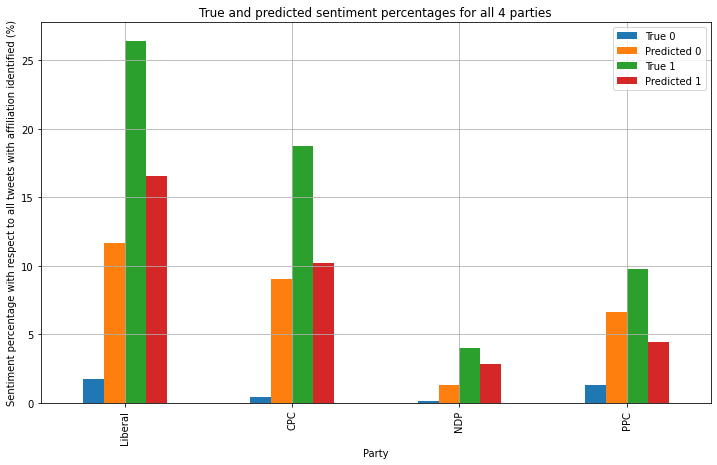

In [177]:
sentdf=pd.concat([truesentdf,predsentdf],axis=1)
#sentdf.columns.values=['True 0','True 1','Predicted 0','Predicted 1']
#sentdf.columns.values=[0,1,2,3]
sentdf.columns.values[2]=2
sentdf.columns.values[3]=3
sentdf.rename(columns = {0:'True 0',1:'True 1',2:'Predicted 0',3:'Predicted 1'}, inplace=True)
(a,b)=sentdf.shape
for i in range(a):
    for j in range(b):
        sentdf.iloc[i,j]=sentdf.iloc[i,j]/(len(cedf)-ptycounts0.loc['Other'])*100
pred0=sentdf.loc[:,'Predicted 0']
sentdf=sentdf.drop('Predicted 0',axis=1)
sentdf.insert(loc=1,column='Predicted 0',value=pred0)
sentdf.plot(kind='bar',figsize=[12,7])
plt.title('True and predicted sentiment percentages for all 4 parties')
plt.xlabel('Party')
plt.ylabel('Sentiment percentage with respect to all tweets with affiliation identified (%)')
plt.grid()

As shown in the model above, Liberal has the best reputation as it has the largest number of true positives. Conservative is supported by the second largest population but significantly lower than Liberal. PPC is the third popular but significantly lower than Conservative. NDP enjoys the lowest popularity as it got the fewest true positives. Evidently, the favorate party of the public is Liberal. It should be addressed that the drastic difference between the number of positives and negatives for all parties is due to a very inbalanced identified dataset, as most of the negatives were unable to be identified and not included in the plot above. Overall, NLP analysis on tweets provided a generally correct overview of the popularities of all the parties. Thus, it is useful for a party to get a rough sense about itself's position and the positions of competing parties during election.

As shown in the plot above, clearly, the model wrongly predicts many 1s to be 0s, as mentioned before. This issue could be mainly due to the difference between the natures of the training data and the testing data. By viewing the word frequency plots of the training data (sentiment analysis) and the testing data (canadian election), the high frequency words are very different. Many of the words appear frequently in the training data seldomly appears in the testing data, where those frequent words in the testing data are also not as frequent in the training data. The main cause could be that the training data are chattings under a broad range of topics, while the testing data are focused on election. As talking about election is more serious than chatting, it could be more likely to be classified as negative with the chatting standard. Also, the tweets about election has more depth than free chatting, while the learning model does not interpret as it does not consider the order of words. A good example could be the third tweet about election, which contains the phrase 'against hate'. It is actually positive but classified as negative, probably due to the word 'hate' detected. However, it does not know 'against' is before 'hate', making its meaning totally different. 

Another aspect is that the portion of true negative sentiments is quite low. This is because many of the negative tweets on the election were just complaining about one or two parties but not showing its affiliation, thus unable to be assigned a party. On the other hand, most of the positive tweets are praising one party, thus easy to be assigned.

In [178]:
sentdf

,True 0,Predicted 0,True 1,Predicted 1
Liberal,1.772526,11.669129,26.440177,16.543575
CPC,0.443131,9.010340,18.759232,10.192024
NDP,0.147710,1.329394,3.988183,2.806499
PPC,1.329394,6.646972,9.748892,4.431315


## Reasons for negative impressions about a party 

In [77]:
#count negative tweets
cedf2.copy().groupby('sentiment').count()

,text,negative_reason,Party,predicted sentiment
sentiment,,,,
0,387,387,387,387
1,615,0,615,615


In [251]:
#separate negative tweets
cedf4b=cedf.copy()
indexs=[]
for i in range(len(cedf)):
    if cedf.loc[i,'sentiment']==1:
        indexs.append(i)
cedf4b=cedf4b.drop(indexs).drop('sentiment',axis=1).reset_index().drop('index',axis=1)
#combine negative reasons 'women reproductive right and racism' and 'segregation' into 'discrimination' because they are similar and 
#they appeared for the fewest times among all reasons.Such lack of samples will lead to serious underfitting. 
for i in range(len(cedf4b)):
    if cedf4b.loc[i,'negative_reason']=='women reproductive right and racism':
        cedf4b.loc[i,'negative_reason']='discrimination'
    elif cedf4b.loc[i,'negative_reason']=='segregation':
        cedf4b.loc[i,'negative_reason']='discrimination'
cedf4b

,text,negative_reason,Party
0,canadian election power grab pm trudeau yes ta...,calling election early,Other
1,hope trudeau loses canadian election tomorrow ...,covid,Other
2,canadian friends never forget trudeau 2 years ...,calling election early,Other
3,vaccines guns key election toole serious plan ...,covid,Other
4,sorry moderators respond leadership candidates...,others,Other
...,...,...,...
382,absolutely horrible canada forthcoming electio...,others,Other
383,davidakin trudeau imposes gun control policies...,gun control,Other
384,canada election stolen thugs uneducated goons ...,others,Other
385,toole amends platform gun control questions re...,tell lies,Other


In [252]:
#IF-IDF transform
ce4bctdf=text2count4df(cedf4b,'text',Xnum=Xnum)
tfidfTF= TfidfTransformer(smooth_idf=False)
ce4bctsubdf=ce4bctdf.iloc[:,0:-2]
ce4bctaftdf=tfidfTF.fit_transform(ce4bctsubdf)
ce4bctaftdf=ce4bctaftdf.toarray()
ce4btfdf=ce4bctdf.copy()
ce4btfdf.iloc[:,0:len(ce4bctaftdf[0])]=ce4bctaftdf
ce4btfdf

len(wordpool)==0
retcols num: 2489
colsdict formed


,election,trudeau,canadians,otoole,canada,canadian,pandemic,justintrudeau,elxn44,like,...,exploited,labour,amends,remain,manipulation,suffering,belligerence,quick,negative_reason,Party
0,0.048078,0.067633,0.000000,0.000000,0.000000,0.093939,0.100419,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,calling election early,Other
1,0.049680,0.069888,0.000000,0.000000,0.000000,0.097071,0.000000,0.000000,0.000000,0.112097,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,covid,Other
2,0.053893,0.075814,0.000000,0.000000,0.000000,0.105302,0.000000,0.000000,0.117221,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,calling election early,Other
3,0.051284,0.000000,0.142756,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,covid,Other
4,0.051187,0.000000,0.071243,0.000000,0.000000,0.000000,0.000000,0.000000,0.111336,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,others,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,0.050691,0.000000,0.000000,0.000000,0.093332,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,others,Other
383,0.000000,0.071716,0.000000,0.091532,0.000000,0.000000,0.000000,0.000000,0.110884,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,gun control,Other
384,0.054392,0.000000,0.000000,0.000000,0.100147,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.261198,0.261198,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,others,Other
385,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.389972,0.389972,0.000000,0.000000,0.000000,0.000000,tell lies,Other


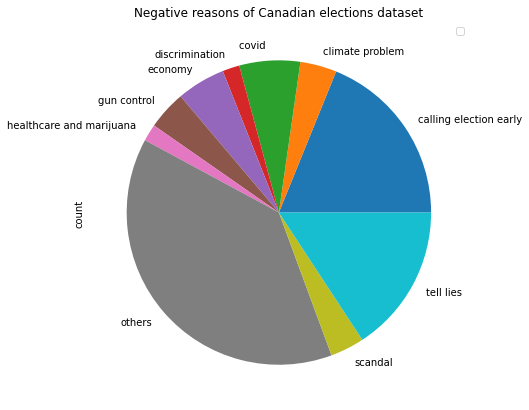

In [254]:
cenegcntdf=cedf4b.groupby('negative_reason').count().drop('Party',axis=1)
cenegcntdf.rename(columns = {'text':'count'},inplace=True)
cenegcntdf.plot(kind='pie',figsize=[12,7],subplots=1)
plt.title('Negative reasons of Canadian elections dataset')
plt.legend([])

In [321]:
cenegcntdf

,count
negative_reason,
calling election early,73
climate problem,15
covid,25
discrimination,7
economy,20
gun control,16
healthcare and marijuana,7
others,149
scandal,14


In [255]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1,\
                        train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy'):
    
    plt.figure(figsize=(10,6))
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,\
                     train_scores_mean + train_scores_std, alpha=0.1, \
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,\
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    
    return plt

In [256]:
#train test split
Xce4b=ce4btfdf.copy().drop(['negative_reason','Party'],axis=1)
yce4b=ce4btfdf.loc[:,'negative_reason']
X4btrain, X4btest, y4btrain, y4btest = train_test_split(Xce4b,yce4b,test_size=0.3)

In [268]:
#Run with default parameters once
model4b=RandomForestClassifier(max_features='log2')
model4b.fit(X4btrain,y4btrain)
pred4b=model4b.predict(X4btest)
accuracy_score(pred4b,y4btest)

0.49572649572649574

In [258]:
#gridsearch
reg_gridsearch = RandomForestClassifier()
#Parameters to test
grid_values = {'max_features':['log2','sqrt'],'criterion': ['gini','entropy'], 'min_samples_split': [2,4,6,10],'n_estimators':[200,300,500],
               'min_samples_leaf':[1,2],'max_leaf_nodes':[500,2000,5000]}
# Run the grid search
grid_obj_lm = GridSearchCV(estimator=reg_gridsearch, param_grid=grid_values, scoring='accuracy')
grid_result = grid_obj_lm.fit(X4btrain,y4btrain)
reg_gridsearch = grid_obj_lm.best_estimator_  #Select best parameter combination
params=reg_gridsearch.get_params()

In [214]:
params

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': 5000,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

D:\Programs\anaconda\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


<module 'matplotlib.pyplot' from 'D:\\Programs\\anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

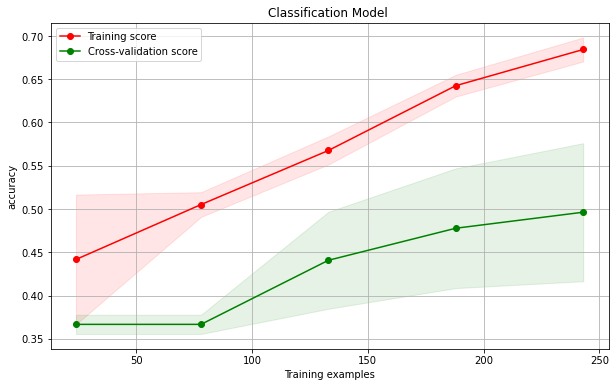

In [259]:
#try the 10 fold cross validation
model4bf=RandomForestClassifier(criterion=params['criterion'],max_features=params['max_features'],max_leaf_nodes=params['max_leaf_nodes'],
                               min_samples_leaf=params['min_samples_leaf'],min_samples_split=params['min_samples_split'],
                               n_estimators=params['n_estimators'])
#model4bf.set_params(params)
kfold = KFold(n_splits=10)
kfold.get_n_splits(X4btrain)
np_idx = 0
accinfd=[]
for train_idx, test_idx in kfold.split(X4btrain):
    X_train, X_test = X4btrain.values[train_idx], X4btrain.values[test_idx]
    y_train, y_test = y4btrain.values[train_idx], y4btrain.values[test_idx]

    model4bf.fit(X_train, y_train)

    predictions = model4bf.predict(X_test)

    ACC = accuracy_score(predictions,y_test)
    accinfd.append(ACC*100)

pltitle='Classification Model '
plot_learning_curve(model4bf,pltitle, X4btrain, y4btrain, cv=10)


In [260]:
#accuracies of each fold
accinfd

[59.25925925925925,
 66.66666666666666,
 59.25925925925925,
 62.96296296296296,
 33.33333333333333,
 44.44444444444444,
 55.55555555555556,
 33.33333333333333,
 62.96296296296296,
 40.74074074074074]

In [261]:
#use 10 fold validated model to predict on the testing data
pred4bf=model4bf.predict(X4btest)
accuracy_score(pred4bf,y4btest)
#some increase in accuracy but still poor

0.5128205128205128

In [281]:
#go back to train the model without cross validation with tuned parameters
model4b2=RandomForestClassifier(criterion=params['criterion'],max_features=params['max_features'],max_leaf_nodes=params['max_leaf_nodes'],
                               min_samples_leaf=params['min_samples_leaf'],min_samples_split=params['min_samples_split'],
                               n_estimators=params['n_estimators'])
model4b2.fit(X4btrain,y4btrain)
pred4b=model4b2.predict(X4btest)
accuracy_score(pred4b,y4btest)
#some increase in accuracy but still poor, no improve from 10-fold validated model

0.5128205128205128

In [345]:
print('#382:',cedf.iloc[382,0],'\n')
print('#625:',cedf.iloc[625,0],'\n')
print('#16:',cedf.iloc[16,0],'\n')
#print(cedf.iloc[112,0],'\n')
print('common words between tweets #382 and #625:')
for word in cedf.iloc[382,0].split():
    if word in cedf.iloc[625,0].split():
        print (word)
print('common words between tweets #382 and #16:')
for word in cedf.iloc[382,0].split():
    if word in cedf.iloc[16,0].split():
        print (word)

#382: canadians really got caught russia trump election meddling look kind meddling ok americans always meddle elections ok cuz obama cool elxn44 

#625: history 18september year2019 election interest photo canadian pm justin trudeau wearing brownface 2001 emerges canadian election campiagn 

#16: misspoke earlier scandal ethics commissioner cleared pmjt wrongdoing way otoole singh targeted woman mental illness amp speaks topic help others order score political points says enough character 

common words between tweets #382 and #625:
election
common words between tweets #382 and #16:


4(c)

In [287]:
posdexs=[]
negdexs=[]
for i in range(len(cedf)):
    if cedf.loc[i,'sentiment']==1:
        posdexs.append(i)
    else:
        negdexs.append(i)
ceposdf=cedf.iloc[posdexs,:]
ceposdf=text2count4df(ceposdf,'text',Xnum=50)
print('top 50 most frequent words (positive):')
ceposdf.columns.values[0:50]

len(wordpool)==0
retcols num: 50
colsdict formed
top 50 most frequent words (positive):


array(['election', 'vote', 'canadian', 'trudeau', 'canadians', 'canada',
       'otoole', 'good', 'elxn44', 'win', 'federal', 'party', 'get',
       'like', 'cdnpoli', 'ppc', 'freedom', 'day', 'best',
       'justintrudeau', 'erinotoole', 'people', 'ndp', 'voteppc', 'us',
       'would', 'better', 'great', 'liberal', 'right', 'support',
       'justin', 'want', 'voting', 'hope', 'need', 'time', 'love',
       'conservatives', 'let', 'voted', 'toole', 'one', 'think',
       'conservative', 'voteliberal', 'go', 'make', 'please', 'cpc'],
      dtype=object)

In [94]:
print('top 50 most frequent words (negative):')
ce4bctdf.columns.values[0:50]

array(['election', 'trudeau', 'canadians', 'otoole', 'canada', 'canadian',
       'pandemic', 'justintrudeau', 'elxn44', 'like', 'vote', 'toole',
       'cdnpoli', 'called', 'party', 'erinotoole',
       'nevervoteconservative', 'pm', 'people', 'years', 'never', 'get',
       'justin', 'conservatives', 'one', 'gun', 'call', 'us', 'would',
       'erin', 'care', 'calling', 'country', 'many', 'conservative',
       'know', 'leader', 'going', 'good', 'covid', 'think', 'unnecessary',
       'say', 'liberals', 'bad', 'million', 'government', 'way', 'ppc',
       'liberal'], dtype=object)

In [288]:
pd.DataFrame({'Frequent Words (positive)':ceposdf.columns.values[0:50],'Frequent Words (negative)':ce4bctdf.columns.values[0:50]})

,Frequent Words (positive),Frequent Words (negative)
0,election,election
1,vote,trudeau
2,canadian,canadians
3,trudeau,otoole
4,canadians,canada
5,canada,canadian
6,otoole,pandemic
7,good,justintrudeau
8,elxn44,elxn44
9,win,like


It is found that many of the frequent words about the election event itself are common for positive and negative sentiments. Also, Trudeau and OToole are frequently mentioned in both positive and negative tweets, meaning the Liberal party and the Conservative party are very controversial. As known, these two parties earned the highest votes, way higher than the other two parties. So it is reasonable to conclude that the party getting the most vote is actually not satisfied by a considerable number of people. Also, words related to NDP and PPC are not mentioned very frequently in the negative tweets. They actually appear more in the positive tweets than in the negative ones. However, the result is they did not receive as many votes as Liberal and CPC. This could probably be due to their lower popularity, thus they also receive fewer criticizes. 

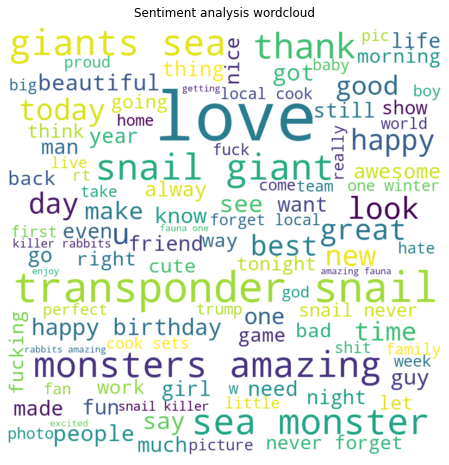

In [362]:
try:
    from wordcloud import WordCloud, ImageColorGenerator
except:
    !pip install wordcloud
    from wordcloud import WordCloud, ImageColorGenerator
text=' '.join(sacollect)
#print(text)
wordcloud = WordCloud(max_words=100, background_color="white",width=800,height=800).generate(text)
plt.figure(figsize=[8,8])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Sentiment analysis wordcloud')
plt.show()

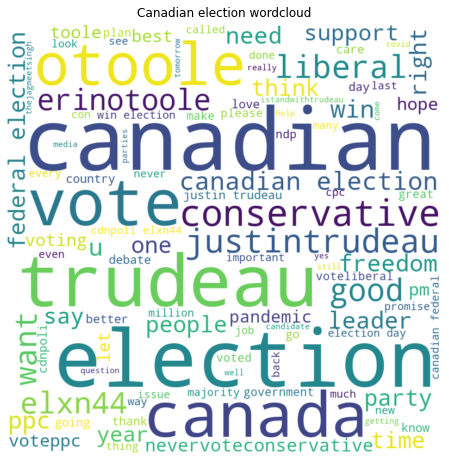

In [363]:
text=' '.join(cecollect)
wordcloud = WordCloud(max_words=100, background_color="white",width=800,height=800).generate(text)
plt.figure(figsize=[8,8])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Canadian election wordcloud')
plt.show()